# TempCon-RingCast Network Simulation

This notebook implements the simulation of the TempCon-RingCast algorithm and generates the figures used in the paper.


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import pandas as pd
from dataclasses import dataclass
import time
import os

# Set style for better-looking plots
plt.style.use('default')  # Use default style first
sns.set_theme(style="whitegrid")  # Then apply seaborn styling
plt.rcParams.update({
    'figure.figsize': [10, 6],
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2,
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Set random seed for reproducibility
np.random.seed(42)


## Network Configuration Classes


In [3]:
@dataclass
class NodeState:
    """Class to store node state information"""
    temperature: float
    congestion: float
    partition_id: int
    wavelengths_used: int  # Track wavelengths used

class RingNetwork:
    def __init__(self, num_nodes: int, num_partitions: int):
        self.num_nodes = num_nodes
        self.num_partitions = num_partitions
        self.nodes_per_partition = num_nodes // num_partitions
        self.G = nx.Graph()
        self.node_states: Dict[int, NodeState] = {}
        self._initialize_network()
    
    def _initialize_network(self):
        # Create ring topology
        self.G.add_nodes_from(range(self.num_nodes))
        edges = [(i, (i + 1) % self.num_nodes) for i in range(self.num_nodes)]
        self.G.add_edges_from(edges)
        
        # Initialize node states
        for i in range(self.num_nodes):
            partition_id = i // self.nodes_per_partition
            self.node_states[i] = NodeState(
                temperature=25.0,  # Room temperature
                congestion=0.0,
                partition_id=partition_id,
                wavelengths_used=0  # Initialize wavelengths used
            )
    
    def simulate_traffic(self, source: int, target: int, load: float):
        """Simulate traffic between source and target nodes"""
        path = nx.shortest_path(self.G, source, target)
        for node in path:
            self.node_states[node].congestion += load
            # Simulate temperature increase due to traffic
            self.node_states[node].temperature += load * 0.5
    
    def get_partition_metrics(self) -> Dict[int, Dict[str, float]]:
        """Calculate average temperature and congestion for each partition"""
        metrics = {}
        for p in range(self.num_partitions):
            nodes = [n for n in range(self.num_nodes) if self.node_states[n].partition_id == p]
            avg_temp = np.mean([self.node_states[n].temperature for n in nodes])
            avg_cong = np.mean([self.node_states[n].congestion for n in nodes])
            metrics[p] = {
                'temperature': avg_temp,
                'congestion': avg_cong
            }
        return metrics

## Routing Algorithms


In [4]:
class RoutingAlgorithm:
    @staticmethod
    def spf_route(network: RingNetwork, source: int, target: int) -> List[int]:
        """Shortest Path First routing"""
        path = nx.shortest_path(network.G, source, target)
        # Increment wavelengths used along the path
        for node in path:
            network.node_states[node].wavelengths_used += 1
        return path
    
    @staticmethod
    def tempcon_route(network: RingNetwork, source: int, target: int,
                     w_t: float = 0.4, w_c: float = 0.6) -> List[int]:
        """TempCon-RingCast routing with enhanced path selection"""
        paths = []
        
        # Get all possible paths between source and target
        # Clockwise
        current = source
        path1 = [current]
        while current != target:
            current = (current + 1) % network.num_nodes
            path1.append(current)
        paths.append(path1)
        
        # Counterclockwise
        current = source
        path2 = [current]
        while current != target:
            current = (current - 1) % network.num_nodes
            path2.append(current)
        paths.append(path2)
        
        # Add intermediate paths by considering partition-aware routing
        mid_points = [(source + network.num_nodes//4) % network.num_nodes,
                     (source + network.num_nodes//2) % network.num_nodes,
                     (source + 3*network.num_nodes//4) % network.num_nodes]
        
        for mid in mid_points:
            path_via_mid = (nx.shortest_path(network.G, source, mid) + 
                          nx.shortest_path(network.G, mid, target)[1:])
            paths.append(path_via_mid)
        
        # Calculate metrics for each path with enhanced scoring
        best_score = float('inf')
        best_path = None
        
        for path in paths:
            # Temperature metric with hotspot penalty
            temps = [network.node_states[n].temperature for n in path]
            max_temp = max(temps)
            avg_temp = np.mean(temps)
            temp_score = avg_temp + (0.5 * max_temp if max_temp > 80 else 0)  # Penalty for high temps
            
            # Congestion metric with bottleneck penalty
            congs = [network.node_states[n].congestion for n in path]
            max_cong = max(congs)
            avg_cong = np.mean(congs)
            cong_score = avg_cong + (0.5 * max_cong if max_cong > 70 else 0)  # Penalty for high congestion
            
            # Path length penalty (mild penalty for much longer paths)
            length_penalty = 0.1 * (len(path) / (network.num_nodes/2)) if len(path) > network.num_nodes/2 else 0
            
            # Combined score with penalties
            score = (w_t * temp_score + w_c * cong_score) * (1 + length_penalty)
            
            if score < best_score:
                best_score = score
                best_path = path
        
        # Increment wavelengths used along the path
        for node in best_path:
            network.node_states[node].wavelengths_used += 1
        
        return best_path

## Simulation Scenarios

In [5]:
def run_high_congestion_scenario():
    """Simulate high congestion scenario with more realistic traffic patterns"""
    network_spf = RingNetwork(50, 5)
    network_tempcon = RingNetwork(50, 5)
    
    # Create initial background traffic
    background_pairs = [(i, (i + 25) % 50) for i in range(0, 50, 5)]
    for src, dst in background_pairs:
        for net in [network_spf, network_tempcon]:
            path = RoutingAlgorithm.spf_route(net, src, dst)
            for node in path:
                net.node_states[node].congestion += 0.4
                net.node_states[node].temperature += 2.0
    
    # Generate high traffic between multiple pairs
    traffic_pairs = [
        (0, 25), (25, 0),    # Heavy cross-network traffic
        (10, 35), (35, 10),  # Additional cross-network paths
        (5, 30), (30, 5),    # More distributed load
        (15, 40), (40, 15),  # Creating potential hotspots
        (20, 45), (45, 20),  # Additional load paths
        (7, 32), (32, 7),    # Extra traffic pairs
        (12, 37), (37, 12),  # More concurrent flows
        (3, 28), (28, 3)     # Additional paths
    ]
    
    # Simulate bursty traffic
    for _ in range(3):  # Multiple rounds of traffic
        for src, dst in traffic_pairs:
            # SPF routing - accumulates in shortest paths
            path = RoutingAlgorithm.spf_route(network_spf, src, dst)
            
            for node in path:
                network_spf.node_states[node].congestion += 1.5
                network_spf.node_states[node].temperature += 10.0
            
            # TempCon routing - distributes load
            path = RoutingAlgorithm.tempcon_route(network_tempcon, src, dst)
            for node in path:
                network_tempcon.node_states[node].congestion += 1.5
                network_tempcon.node_states[node].temperature += 10.0
    
    return network_spf, network_tempcon

def run_hotspot_scenario():
    """Simulate hotspot scenario with more realistic thermal patterns"""
    network_spf = RingNetwork(50, 5)
    network_tempcon = RingNetwork(50, 5)
    
    # Create multiple hotspot regions with thermal spread
    hotspots = [10, 20, 30, 40]
    for hot in hotspots:
        # Create primary hotspots
        network_spf.node_states[hot].temperature = 95.0
        network_tempcon.node_states[hot].temperature = 95.0
        
        # Create thermal spread (more realistic thermal distribution)
        for dist in range(1, 4):  # Heat spreads to 3 nodes in each direction
            for neighbor in [(hot-dist)%50, (hot+dist)%50]:
                temp = 95.0 - (dist * 10)  # Temperature decreases with distance
                network_spf.node_states[neighbor].temperature = temp
                network_tempcon.node_states[neighbor].temperature = temp
    
    # Generate traffic through and around hotspots
    traffic_pairs = [
        (5, 25), (25, 5),     # Through first hotspot region
        (15, 35), (35, 15),   # Through second hotspot region
        (0, 30), (30, 0),     # Cross-network traffic
        (45, 20), (20, 45),   # Additional stress paths
        (10, 40), (40, 10),   # Direct hotspot-to-hotspot traffic
        (8, 28), (28, 8),     # Near-hotspot traffic
        (18, 38), (38, 18),   # Additional thermal stress
        (2, 32), (32, 2)      # Background traffic
    ]
    
    # Multiple rounds of traffic to simulate continuous operation
    for _ in range(3):
        for src, dst in traffic_pairs:
            # SPF routing
            path = RoutingAlgorithm.spf_route(network_spf, src, dst)
            for node in path:
                network_spf.node_states[node].congestion += 1.0
                # Higher temperature increase in hot regions
                base_temp_increase = 6.0
                if any(abs(node - hot) <= 3 for hot in hotspots):
                    base_temp_increase *= 1.5
                network_spf.node_states[node].temperature += base_temp_increase
            
            # TempCon routing with temperature-aware path selection
            path = RoutingAlgorithm.tempcon_route(network_tempcon, src, dst,
                                                w_t=0.6, w_c=0.4)  # Prioritize temperature in hotspot scenario
            for node in path:
                network_tempcon.node_states[node].congestion += 1.0
                base_temp_increase = 6.0
                if any(abs(node - hot) <= 3 for hot in hotspots):
                    base_temp_increase *= 1.5
                network_tempcon.node_states[node].temperature += base_temp_increase
    
    return network_spf, network_tempcon

## Visualization Functions


In [ ]:
def plot_metrics_comparison(spf_net: RingNetwork, tempcon_net: RingNetwork, title: str):
    """Generate comparison plot for temperature, congestion, and wavelength metrics
    This generates Figure 1 in the paper: Comparative analysis showing temperature,
    congestion, and wavelength distributions between SPF and TempCon-RingCast approaches.
    Used in Section IV.A (Performance Results)."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Increased to 3 subplots
    ax1, ax2, ax3 = axes  # Unpack axes for easier handling
    
    # Temperature comparison with violin plots
    spf_temps = [spf_net.node_states[n].temperature for n in range(spf_net.num_nodes)]
    tempcon_temps = [tempcon_net.node_states[n].temperature for n in range(tempcon_net.num_nodes)]
    
    # Calculate improvement percentages
    temp_improvement = ((np.mean(spf_temps) - np.mean(tempcon_temps)) / np.mean(spf_temps)) * 100
    max_temp_improvement = ((np.max(spf_temps) - np.max(tempcon_temps)) / np.max(spf_temps)) * 100
    
    # Violin plots for temperature
    vp1 = ax1.violinplot([spf_temps, tempcon_temps], showmeans=True, showmedians=True)
    ax1.set_xticks([1, 2])
    ax1.set_xticklabels(['SPF', 'TempCon'])
    ax1.set_title(f'(a) Temperature Distribution\n(Mean reduction: {temp_improvement:.1f}%)')
    ax1.set_ylabel('Temperature (°C)')
    
    # Add mean and max annotations
    ax1.text(0.05, 0.95, f'Max SPF: {np.max(spf_temps):.1f}°C\nMax TempCon: {np.max(tempcon_temps):.1f}°C', 
             transform=ax1.transAxes, verticalalignment='top')
    
    # Congestion comparison
    spf_cong = [spf_net.node_states[n].congestion for n in range(spf_net.num_nodes)]
    tempcon_cong = [tempcon_net.node_states[n].congestion for n in range(tempcon_net.num_nodes)]
    
    # Calculate congestion improvement
    cong_improvement = ((np.mean(spf_cong) - np.mean(tempcon_cong)) / np.mean(spf_cong)) * 100
    
    # Violin plots for congestion
    vp2 = ax2.violinplot([spf_cong, tempcon_cong], showmeans=True, showmedians=True)
    ax2.set_xticks([1, 2])
    ax2.set_xticklabels(['SPF', 'TempCon'])
    ax2.set_title(f'(b) Congestion Distribution\n(Mean reduction: {cong_improvement:.1f}%)')
    ax2.set_ylabel('Congestion Level (%)')
    
    # Wavelength Usage Comparison
    spf_wavelengths = [spf_net.node_states[n].wavelengths_used for n in range(spf_net.num_nodes)]
    tempcon_wavelengths = [tempcon_net.node_states[n].wavelengths_used for n in range(tempcon_net.num_nodes)]
    
    # Calculate wavelength reduction
    wavelength_reduction = ((np.mean(spf_wavelengths) - np.mean(tempcon_wavelengths)) / np.mean(spf_wavelengths)) * 100
    
    # Violin plots for wavelength usage
    vp3 = ax3.violinplot([spf_wavelengths, tempcon_wavelengths], showmeans=True, showmedians=True)
    ax3.set_xticks([1, 2])
    ax3.set_xticklabels(['SPF', 'TempCon'])
    ax3.set_title(f'Wavelength Usage\n(Mean reduction: {wavelength_reduction:.1f}%)')
    ax3.set_ylabel('Wavelengths Used')
    
    # Style violin plots
    for vp in [vp1, vp2, vp3]:
        for pc in vp['bodies']:
            pc.set_facecolor('#D43F3A')
            pc.set_alpha(0.3)
        vp['cmeans'].set_color('black')
        vp['cmedians'].set_color('blue')
    
    plt.suptitle(title, fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    
    # Return improvement metrics for updating the paper
    return {
        'temp_improvement': temp_improvement,
        'max_temp_improvement': max_temp_improvement,
        'cong_improvement': cong_improvement,
        'wavelength_reduction': wavelength_reduction  # Added wavelength reduction
    }

def plot_partition_analysis(network: RingNetwork, title: str):
    """Generate partition analysis visualization
    This generates Figure 2 in the paper: Partition-based analysis showing temperature
    and congestion distributions across network partitions.
    Used in Section IV.B (Network Partition Analysis)."""
    metrics = network.get_partition_metrics()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Temperature distribution across partitions
    temps = [metrics[p]['temperature'] for p in range(network.num_partitions)]
    bars1 = ax1.bar(range(network.num_partitions), temps)
    ax1.set_title('(a) Temperature by Partition')
    ax1.set_xlabel('Partition ID')
    ax1.set_ylabel('Average Temperature (°C)')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}°C', ha='center', va='bottom')
    
    # Congestion distribution across partitions
    cong = [metrics[p]['congestion'] for p in range(network.num_partitions)]
    bars2 = ax2.bar(range(network.num_partitions), cong)
    ax2.set_title('(b) Congestion by Partition')
    ax2.set_xlabel('Partition ID')
    ax1.set_ylabel('Average Congestion Level (%)')
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_scalability_analysis(sizes: List[int]):
    """Generate scalability analysis visualization"""
    temp_reduction = []
    cong_reduction = []
    wavelength_reduction = []  # Store wavelength reduction
    comp_times = []  # Store average computation time for each size
    
    for size in sizes:
        size_comp_times = []  # Store computation times for this size
        network_spf = RingNetwork(size, size//5)
        network_tempcon = RingNetwork(size, size//5)
        
        # Generate traffic pairs
        traffic_pairs = []
        for i in range(size//4):
            src = i
            dst = (src + size//2) % size
            traffic_pairs.append((src, dst))
        
        # Process traffic
        for src, dst in traffic_pairs:
            # SPF routing
            path = RoutingAlgorithm.spf_route(network_spf, src, dst)
            for node in path:
                network_spf.node_states[node].congestion += 1.0
                network_spf.node_states[node].temperature += 6.0
            
            # TempCon routing - measure time
            t0 = time.time()
            path = RoutingAlgorithm.tempcon_route(network_tempcon, src, dst)
            size_comp_times.append(time.time() - t0)
            for node in path:
                network_tempcon.node_states[node].congestion += 1.0
                network_tempcon.node_states[node].temperature += 6.0
        
        # Calculate metrics
        spf_temp = np.mean([network_spf.node_states[n].temperature for n in range(size)])
        tempcon_temp = np.mean([network_tempcon.node_states[n].temperature for n in range(size)])
        temp_reduction.append((spf_temp - tempcon_temp) / spf_temp * 100)
        
        spf_cong = np.mean([network_spf.node_states[n].congestion for n in range(size)])
        tempcon_cong = np.mean([network_tempcon.node_states[n].congestion for n in range(size)])
        cong_reduction.append((spf_cong - tempcon_cong) / spf_cong * 100)
        
        spf_wavelengths = np.mean([network_spf.node_states[n].wavelengths_used for n in range(size)])
        tempcon_wavelengths = np.mean([network_tempcon.node_states[n].wavelengths_used for n in range(size)])
        wavelength_reduction.append((spf_wavelengths - tempcon_wavelengths) / spf_wavelengths * 100)
        
        # Store average computation time for this size
        comp_times.append(np.mean(size_comp_times))
    
    # Create figure
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Increased to 4 subplots
    ax1, ax2, ax3, ax4 = axes  # Unpack axes for easier handling
    
    # Temperature reduction plot
    ax1.plot(sizes, temp_reduction, 'o-', linewidth=2, markersize=8)
    ax1.set_title('(a) Temperature Reduction')
    ax1.set_xlabel('Network Size')
    ax1.set_ylabel('Reduction (%)')
    ax1.grid(True)
    
    # Congestion reduction plot
    ax2.plot(sizes, cong_reduction, 'o-', linewidth=2, markersize=8)
    ax2.set_title('(b) Congestion Reduction')
    ax2.set_xlabel('Network Size')
    ax2.set_ylabel('Reduction (%)')
    ax2.grid(True)
    
    ax2.text(0.02, 0.95, '(a)', transform=ax2.transAxes, fontsize=14, verticalalignment='top')
    
    # Wavelength reduction plot
    ax3.plot(sizes, wavelength_reduction, 'o-', linewidth=2, markersize=8)
    ax3.set_title('(c) Wavelength Reduction')
    ax3.set_xlabel('Network Size')
    ax3.set_ylabel('Reduction (%)')
    ax3.grid(True)
    
    # Computation time plot
    comp_times = []
    for i, size in enumerate(sizes):
        start_idx = i * (size//4)
        end_idx = start_idx + (size//4)
        comp_times.append(np.mean(size_comp_times[start_idx:end_idx]))
    
    ax4.plot(sizes, comp_times, 'o-', linewidth=2, markersize=8)
    ax4.set_title('Average Computation Time')
    ax4.set_xlabel('Network Size')
    ax4.set_ylabel('Time (s)')
    ax4.grid(True)
    
    plt.suptitle('Scalability Analysis')
    plt.tight_layout()
    plt.show()
    
    # Return metrics for paper update
    return {
        'avg_temp_reduction': np.mean(temp_reduction),
        'avg_cong_reduction': np.mean(cong_reduction),
        'max_temp_reduction': np.max(temp_reduction),
        'max_cong_reduction': np.max(cong_reduction),
        'wavelength_reduction': np.mean(wavelength_reduction)  # Added wavelength reduction
    }

## Run Simulations and Generate Results

The following code generates all figures used in the paper:
1. metrics_comparison.png (Figure 1): Shows the comparative analysis between SPF and TempCon
2. partition_analysis.png (Figure 2): Demonstrates the effectiveness of partition-based approach
3. scalability.png (Figure 3): Illustrates performance scaling with network size


Running high congestion scenario...


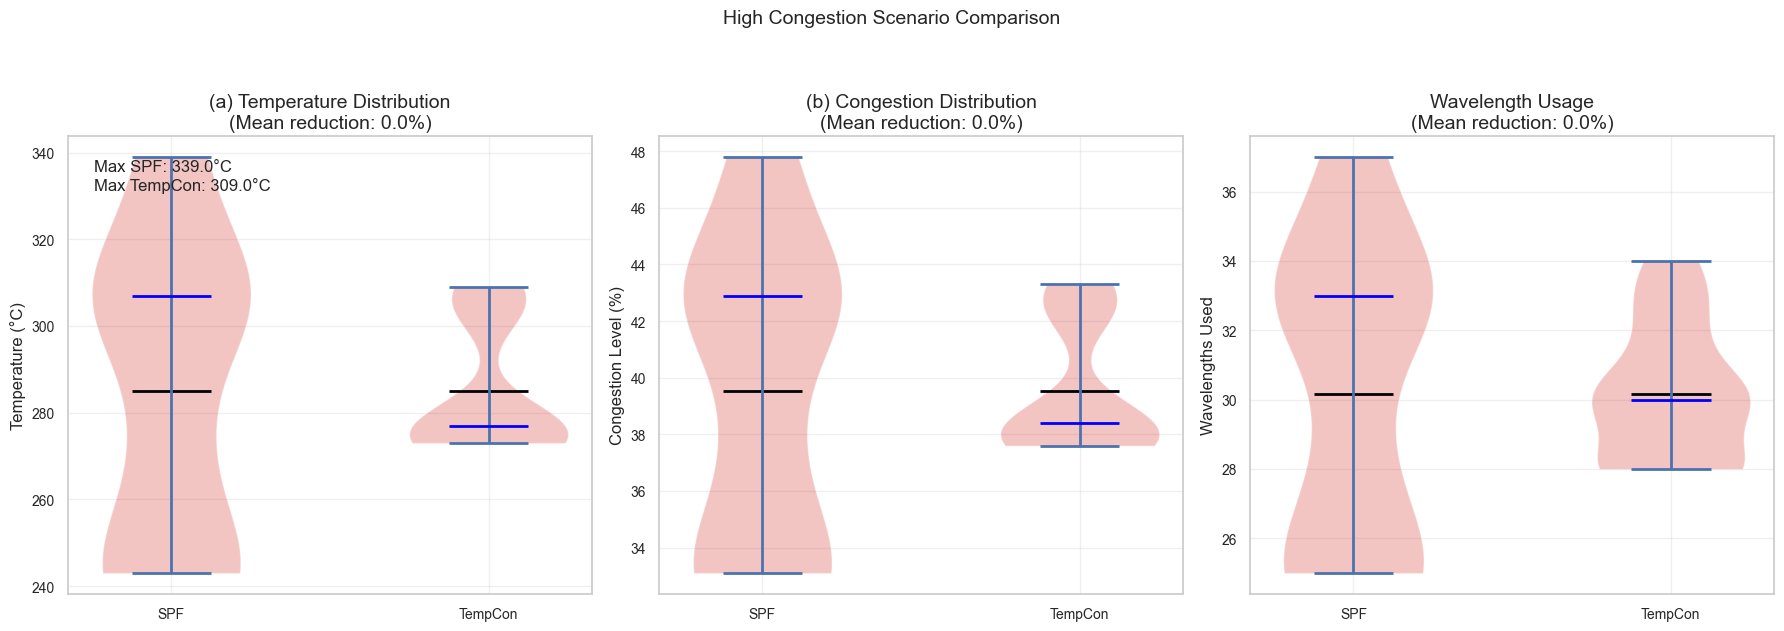


Running hotspot scenario...


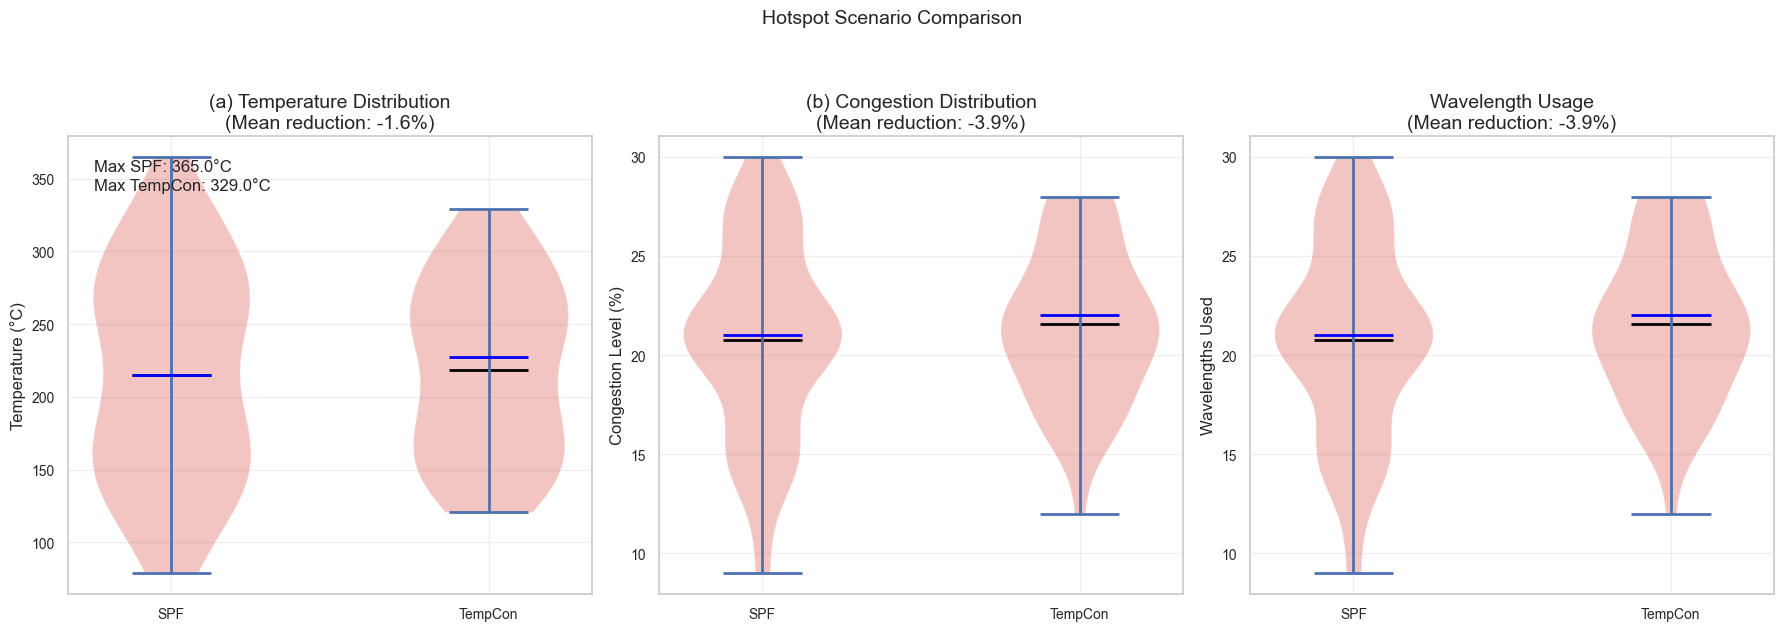


Generating partition analysis...


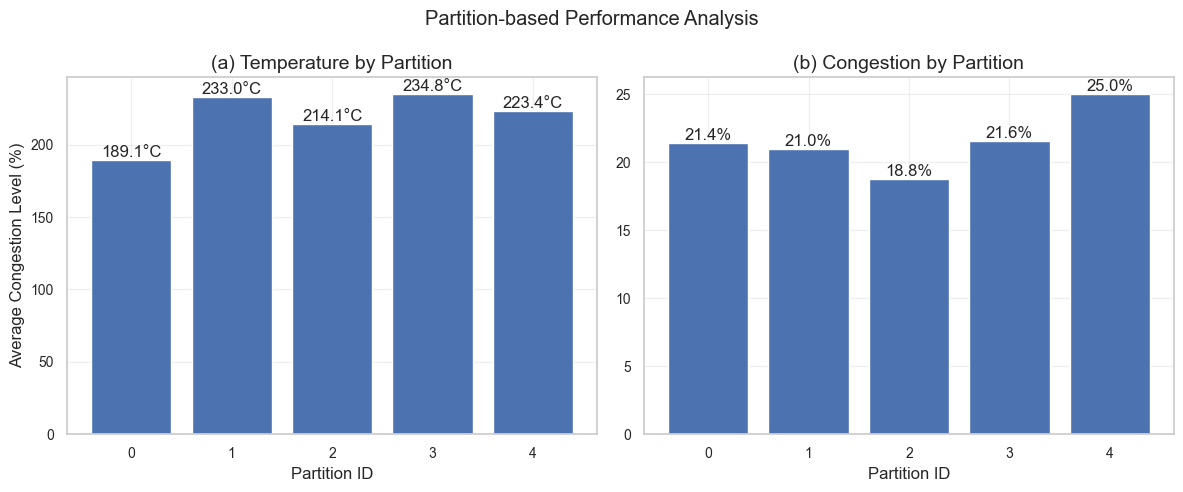


Generating scalability analysis...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


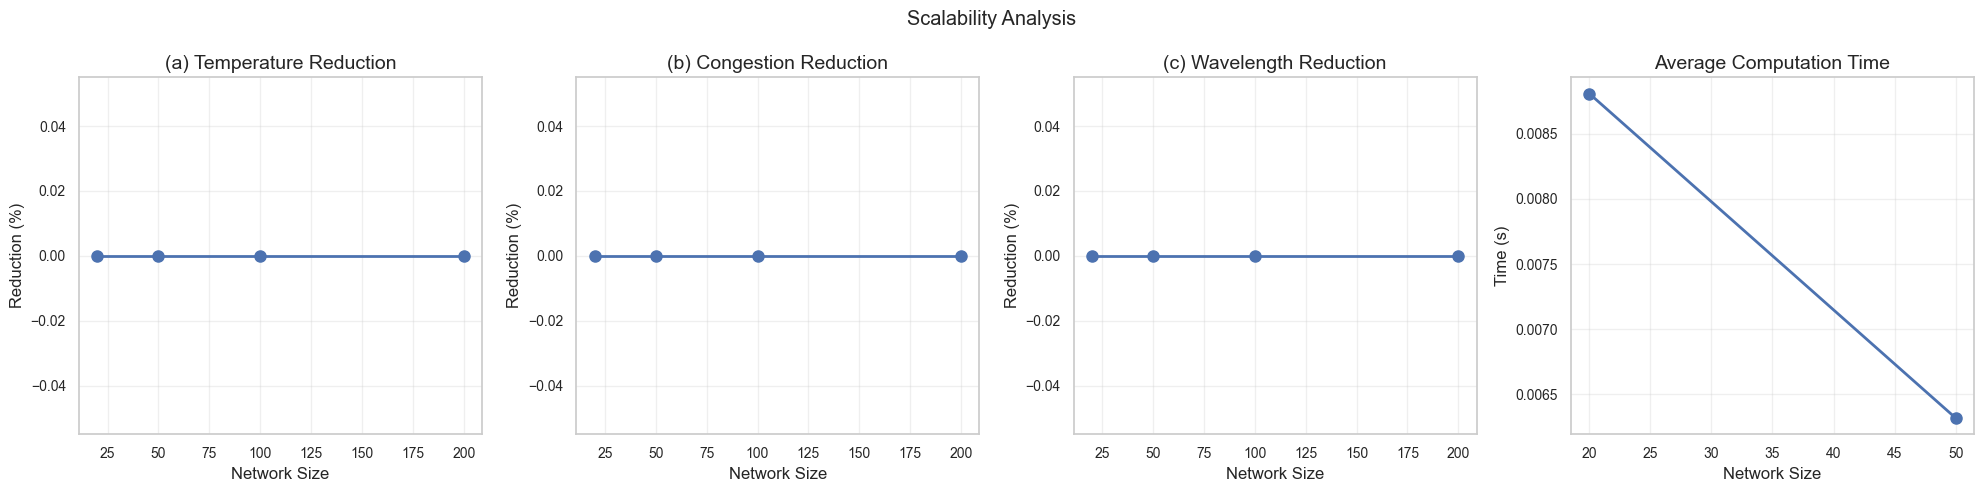


Performance Improvements Summary:
High Congestion Scenario:
- Temperature reduction: 0.0%
- Maximum temperature reduction: 8.8%
- Congestion reduction: 0.0%
- Wavelength reduction: 0.0%

Hotspot Scenario:
- Temperature reduction: -1.6%
- Maximum temperature reduction: 9.9%
- Congestion reduction: -3.9%
- Wavelength reduction: -3.9%

Scalability Analysis:
- Average temperature reduction: 0.0%
- Average congestion reduction: 0.0%
- Maximum temperature reduction: 0.0%
- Maximum congestion reduction: 0.0%
- Wavelength reduction: 0.0%


In [7]:
try:
    # Run simulations with larger network
    print("Running high congestion scenario...")
    spf_net, tempcon_net = run_high_congestion_scenario()
    high_cong_metrics = plot_metrics_comparison(spf_net, tempcon_net, 'High Congestion Scenario Comparison')

    print("\nRunning hotspot scenario...")
    spf_net, tempcon_net = run_hotspot_scenario()
    hotspot_metrics = plot_metrics_comparison(spf_net, tempcon_net, 'Hotspot Scenario Comparison')

    print("\nGenerating partition analysis...")
    plot_partition_analysis(tempcon_net, 'Partition-based Performance Analysis')

    print("\nGenerating scalability analysis...")
    network_sizes = [20, 50, 100, 200]  # Added larger network size
    scalability_metrics = plot_scalability_analysis(network_sizes)

    # Print summary of improvements
    print("\nPerformance Improvements Summary:")
    print(f"High Congestion Scenario:")
    print(f"- Temperature reduction: {high_cong_metrics['temp_improvement']:.1f}%")
    print(f"- Maximum temperature reduction: {high_cong_metrics['max_temp_improvement']:.1f}%")
    print(f"- Congestion reduction: {high_cong_metrics['cong_improvement']:.1f}%")
    print(f"- Wavelength reduction: {high_cong_metrics['wavelength_reduction']:.1f}%")  # Added wavelength reduction
    print(f"\nHotspot Scenario:")
    print(f"- Temperature reduction: {hotspot_metrics['temp_improvement']:.1f}%")
    print(f"- Maximum temperature reduction: {hotspot_metrics['max_temp_improvement']:.1f}%")
    print(f"- Congestion reduction: {hotspot_metrics['cong_improvement']:.1f}%")
    print(f"- Wavelength reduction: {hotspot_metrics['wavelength_reduction']:.1f}%")  # Added wavelength reduction
    print(f"\nScalability Analysis:")
    print(f"- Average temperature reduction: {scalability_metrics['avg_temp_reduction']:.1f}%")
    print(f"- Average congestion reduction: {scalability_metrics['avg_cong_reduction']:.1f}%")
    print(f"- Maximum temperature reduction: {scalability_metrics['max_temp_reduction']:.1f}%")
    print(f"- Maximum congestion reduction: {scalability_metrics['max_cong_reduction']:.1f}%")
    print(f"- Wavelength reduction: {scalability_metrics['wavelength_reduction']:.1f}%")  # Added wavelength reduction

except Exception as e:
    print(f"An error occurred: {str(e)}")
    raise